In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import smplotlib
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14
    
import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nuwa.wlkernel import make_graph, calculate_grakel_graph, GaussianProcess
import multiprocessing
import os
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from scipy.sparse import lil_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree
np.set_printoptions(suppress=True)


data_dir = "/nfsdata/users/jdli_ny/wlkernel/mock/"
data = np.load(data_dir+'binary_train_flatZ_abg.npz')


# Split X and Y into training and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(
    data['X'], data['Y'], test_size=0.1, random_state=42
)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)



(900, 1000, 2) (100, 1000, 2) (900, 2) (100, 2)


In [2]:
for d in [X_train, X_test, Y_train, Y_test]:

    print(len(d[np.isnan(d)]))
    # d = d[~np.isnan(d).any(axis=1)]
    print(d.shape)

0
(900, 1000, 2)
0
(100, 1000, 2)
0
(900, 2)
0
(100, 2)


# train

In [3]:
num_cpu = 24
radius  = 0.1
subsample_factor = 1
n_iter = 3

# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_train[i], radius, subsample_factor) for i in range(X_train.shape[0])])))

    
# Initialize the grakel graph kernel
wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))



100%|██████████| 900/900 [00:17<00:00, 50.46it/s]


In [4]:
# Normalize kernel values
kernel_values = wl_kernel.fit_transform(grakel_list)
kernel_values = kernel_values / np.max(kernel_values)

print(kernel_values)
print(np.linalg.det(kernel_values))

plt.imshow(kernel_values, cmap='bone')


In [47]:
np.linalg.cond(kernel_values)

37449.45625439397

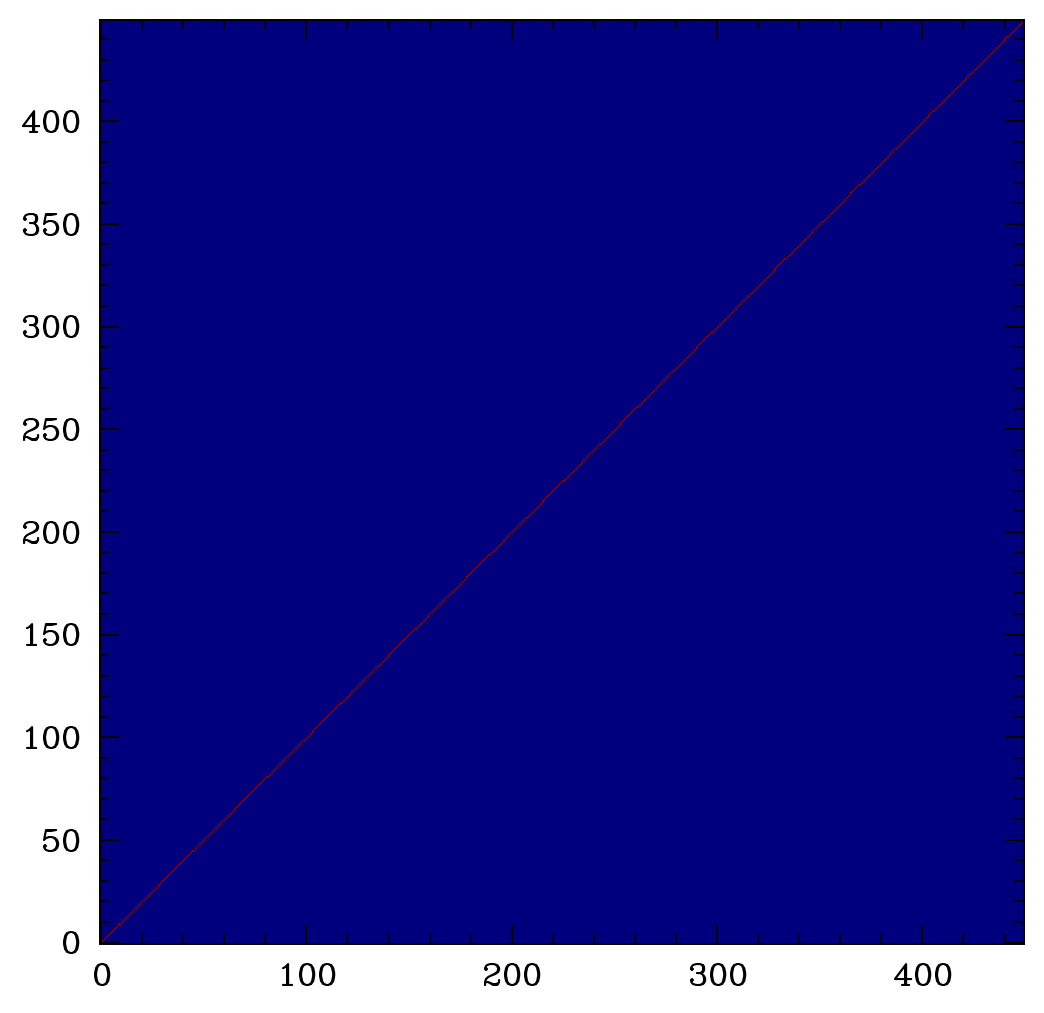

In [49]:
tt = kernel_values @ np.linalg.inv(kernel_values)

plt.imshow(tt)

# validation

In [52]:
# Make the graph objects for all realisations in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    graph_list, degree_list = zip(*pool.map(make_graph, tqdm([(i, X_test[i], radius, subsample_factor) for i in range(X_test.shape[0])])))

    
# wl_kernel = WeisfeilerLehman(n_iter=n_iter, base_graph_kernel=VertexHistogram)
args_list = [(i, graph_list[i], degree_list[i]) for i in range(len(graph_list))]


# Calculate grakel graphs in parallel
with multiprocessing.Pool(processes=num_cpu) as pool:
    grakel_list_test = list(tqdm(pool.imap(calculate_grakel_graph, args_list), total=len(graph_list)))


100%|██████████| 50/50 [00:01<00:00, 37.26it/s]


In [53]:
# Normalize kernel values
K_star = wl_kernel.transform(grakel_list_test)
K_star = K_star / np.max(K_star)


np.save(data_dir+"test_kernel_values_flatZ.npy", K_star)

In [58]:
class GaussianProcess:
    
    def __init__(self, K, K_star, K_star_star=None):
        # self.kernel = kernel
        self.K = K
        self.K_star = K_star
        # self.K_star_star = K_star_star
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
    
    def predict(self):
        # K = self.kernel(self.X_train, self.X_train)
        self.K_inv = np.linalg.inv(self.K)
        
        # K_star = self.kernel(self.X_train, X_test)
        mu = self.K_star @ self.K_inv @ self.y_train
        # cov = self.K_star_star - self.K_star @ self.K_inv @ self.K_star
        return mu
    
gp = GaussianProcess(kernel_values, K_star)
gp.fit(X_train, Y_train)

y_pred = gp.predict()
y_pred

array([[ 0.69203396,  2.53706321],
       [ 0.85315855,  2.68907424],
       [ 0.05893224, -0.37787908],
       [ 0.26252537,  0.56440671],
       [ 1.05863741,  0.75012255],
       [ 0.38520641,  3.55641587],
       [ 0.04674915,  3.07742961],
       [ 0.26862651,  3.7212679 ],
       [ 0.07620081,  3.84780084],
       [ 0.77648059,  1.85503479],
       [ 0.7659522 ,  3.26366503],
       [ 0.38790227,  1.01375697],
       [ 0.42800561,  4.06658557],
       [ 0.2826334 ,  2.04160848],
       [ 0.03012392,  0.26141661],
       [ 0.94807164,  1.12065003],
       [ 0.41490711,  0.5464651 ],
       [ 0.66277254,  3.53157333],
       [ 0.47999162,  2.89924739],
       [ 0.90937951,  0.34655775],
       [ 0.50995317,  4.00832068],
       [ 0.69486729,  3.41829756],
       [ 0.94128236,  2.7819025 ],
       [ 0.04283291,  0.09040946],
       [ 0.94973465,  0.97349579],
       [ 0.70657393,  2.81264543],
       [ 0.09591516,  0.03085349],
       [ 0.68260058,  2.59556567],
       [ 0.69187271,

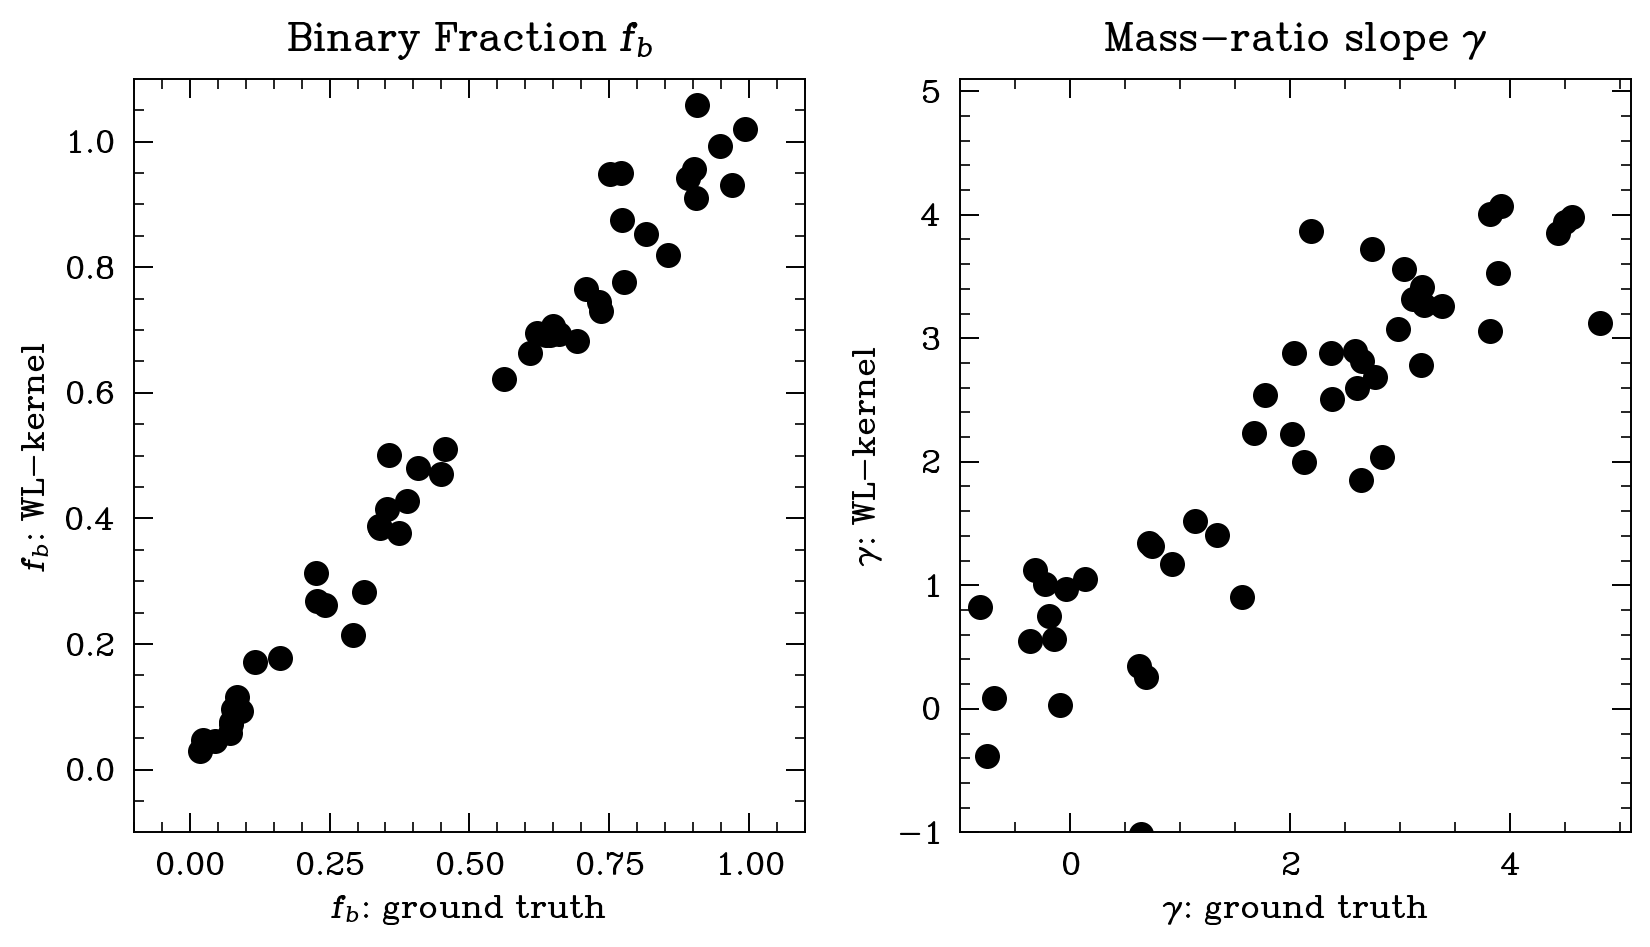

In [59]:
# Create one-to-one comparison plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8.5, 5))

ax1.scatter(Y_test[:,0], y_pred[:,0], )
ax2.scatter(Y_test[:,1], y_pred[:,1], )
ax1.set_xlim(-0.1, 1.1);
ax1.set_ylim(-0.1, 1.1);
ax1.set_xlabel(r"$f_b$: ground truth");
ax1.set_ylabel(r"$f_b$: WL-kernel");


ax2.set_xlim(-1, 5.1);
ax2.set_ylim(-1, 5.1);
ax2.set_xlabel(r"$\gamma$: ground truth");
ax2.set_ylabel(r"$\gamma$: WL-kernel");
ax1.set_title(f'Binary Fraction $f_b$')
ax2.set_title(f'Mass-ratio slope $\gamma$')

plt.tight_layout()

In [64]:
import pickle

model_dir = "/nfsdata/users/jdli_ny/wlkernel/model/"

with open(model_dir+'wl_kernel.pkl', 'wb') as f:
    pickle.dump(wl_kernel, f)


np.save(model_dir+"kernel_values_flatZ.npy", kernel_values)